# Notebook Used to Vizualize the Output of Sequentially Saved Learning

In [1]:
from tqdm import tqdm
from scipy.spatial import distance
from dap import DAPcython
from dap.utils import obs_params, load_current
from utils import calc_features_ramp, calc_features_step

import warnings
warnings.filterwarnings("ignore")

In [2]:
import glob
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
dt = 1e-2
params, labels = obs_params(reduced_model=False)
data_dir = '/home/alteska/Desktop/LFI_DAP/data/rawData/2015_08_26b.dat'

### Get the dir names

In [4]:
# load the file
directory = './parameters/'
dir = glob.glob(directory + '*')
fname = dir[0] + '/'

In [5]:
fname

'./parameters/dap_model_5_param_3x30/'

## Load The Recorded Means and Std
'hyperparam.csv'
'parameters_mean.csv'
'parameters_std.csv'

In [6]:
df_std = pd.read_csv(fname + 'parameters_std' + '.csv')
df_mean = pd.read_csv(fname + 'parameters_mean' + '.csv')
df_hyperparam = pd.read_csv(fname + 'hyperparam' + '.csv')

In [7]:
df_mean.rename(columns={'Unnamed: 0':'id'}, inplace=True)
df_std.rename(columns={'Unnamed: 0':'id'}, inplace=True)
df_mean.set_index('id', inplace=True)
df_std.set_index('id', inplace=True)


In [8]:
df_mean.drop(13, inplace=True)

In [9]:
# df_std.head()

In [10]:
df_hyperparam

,Unnamed: 0,name,n_rounds,n_summary,n_samples,n_hidden,n_components,protocol,ramp_amp,prior_min,prior_max
0,0,_5_param_3x30,20,17,1000,"[30, 30, 30]",1,rampIV,3.1,"[0, 1]","[0.5, 30]"


### Simulate For Each Parameter Set

### calculate DAP

In [11]:
# load the input data
Ir, vr, tr, t_onr, t_offr, dtr = load_current(data_dir, protocol='rampIV', ramp_amp=3.1)
Is, vs, ts, t_ons, t_offs, dts = load_current(data_dir, protocol='IV', ramp_amp=1)

In [12]:
### Set up themodel
params, labels = obs_params(reduced_model=True)
dap = DAPcython(-75, params)
U_ramp = dap.simulate(dtr, tr, Ir)
U_step = dap.simulate(dts, ts, Is)

In [13]:
# get traces for both currents
U_steps, U_ramps = [], []

for i, j in tqdm(df_mean.iterrows()):
    # get parameters
    par_temp = j.values

    # define a model
    dap = DAPcython(-75, j)

    # run model
    U_step_x = dap.simulate(dts, ts, Is)
    U_ramp_x = dap.simulate(dtr, tr, Ir)

    # run model
    U_steps.append(U_step_x.transpose()[0])
    U_ramps.append(U_ramp_x.transpose()[0])

19it [00:22,  1.24s/it]


### Viz all simulations

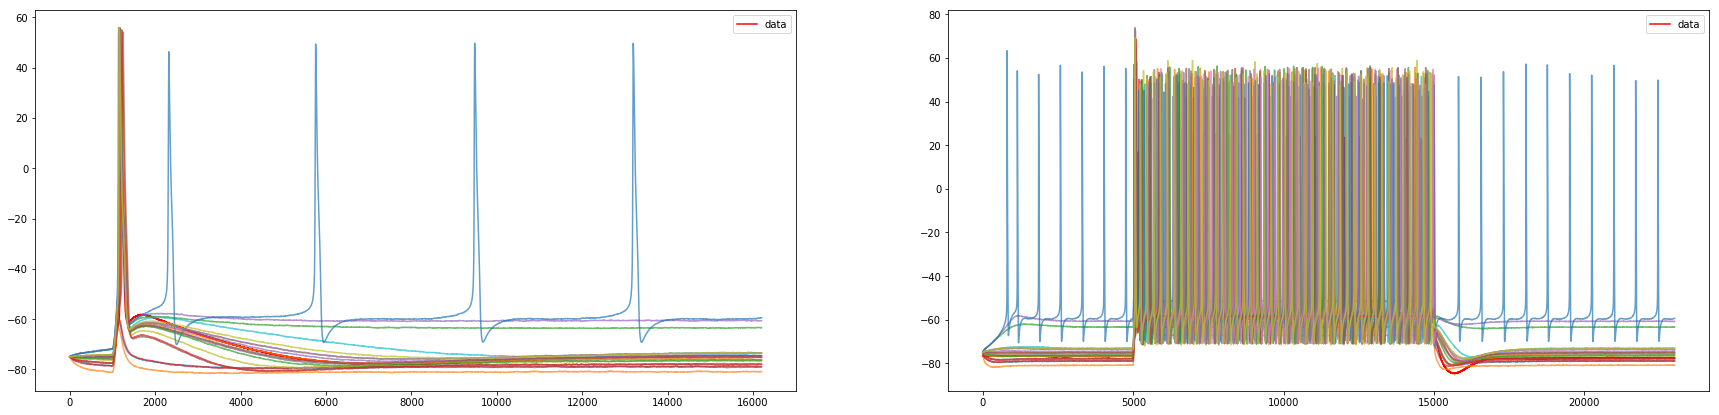

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(30, 7))

ax[0].plot(vr, c='r', label='data');
ax[1].plot(vs, c='r', label='data');

for i, trace in enumerate(U_ramps): 
    ax[0].plot(trace, alpha=0.7)

for i, trace in enumerate(U_steps): 
    ax[1].plot(trace, alpha=0.7)
    
ax[0].legend()
ax[1].legend();


## Calculate Similarity by Features

In [15]:
# create DataFrames for traces
df_step = pd.DataFrame({'step_traces': U_steps})
df_step.set_index(df_mean.index.values, inplace=True)

df_ramp = pd.DataFrame({'ramp_traces': U_ramps})
df_ramp.set_index(df_mean.index.values, inplace=True)

In [16]:
df_traces_temp = pd.merge(df_mean, df_step, how='left', left_index=True, right_index=True)
df_traces = pd.merge(df_traces_temp, df_ramp, how='left', left_index=True, right_index=True)

In [17]:
# Calculate Statistics for Ramp and Step currents
step_features_labels = ['rest_pot', 'rest_pot_std','firing_rate', 'ISI_mean', 'ISI_std', 'spike_count', 'spike_times_stim']
ramp_features_labels = ['rest_pot', 'AP_amp', 'AP_width', 'fAHP', 'DAP_amp', 'DAP_width', 'DAP_deflection','DAP_time', 'mAHP']

In [18]:
stats_step = []
for i,u in enumerate(U_steps):
    stats = calc_features_step(u, ts, dts, t_ons, t_offs)
    stats_step.append(stats)

In [19]:
stats_ramp = []
for i,u in enumerate(U_ramps):
    stats = calc_features_ramp(u, tr, dtr, t_onr, t_offr)
    stats_ramp.append(stats)

In [20]:
# change into data frame
df_ramps = pd.DataFrame(data=stats_ramp, columns=ramp_features_labels, index=df_mean.index)
df_steps = pd.DataFrame(data=stats_step, columns=step_features_labels, index=df_mean.index)

## Calculate The Features

In [21]:
data_feat_ramp = calc_features_ramp(vr, tr, dtr, t_onr, t_offr)
data_feat_ramp

array([-74.9345 , 113.997  ,   0.73   , -59.96875,  14.21575,  19.73   ,
        -0.75   ,   1.39   , -78.09375])

In [22]:
data_feat_step = calc_features_step(vs, ts, dts, t_ons, t_offs)
data_feat_step

array([-76.63358125, 0.06351057982730121, 48.0, 20.62173913043478,
       6.066798921122928, 24,
       array([254.6 , 258.4 , 264.6 , 275.95, 291.85, 309.  , 328.9 , 347.95,
       367.45, 387.1 , 409.75, 432.15, 456.4 , 479.25, 504.55, 527.35,
       552.55, 575.95, 600.95, 626.85, 651.45, 675.85, 703.5 , 728.9 ])],
      dtype=object)

## Create Comparison DF

#### Ramp Current

In [23]:
df_diff_ramps = np.abs(df_ramps.copy() - data_feat_ramp)
df_diff_ramps['sum'] = df_diff_ramps.sum(axis=1)
df_diff_ramps['sum'] = np.abs(df_diff_ramps['sum'])

df_diff_ramps.index.rename('id', inplace=True)
df_diff_ramps.reset_index(level=0, inplace=True)


#### Step Current

In [24]:
df_diff_steps = df_steps.dropna()
df_diff_steps.drop('spike_times_stim', axis=1, inplace=True)
df_diff_steps = np.abs(df_diff_steps - data_feat_step[:-1])

df_diff_steps.index.rename('id', inplace=True)
df_diff_steps.reset_index(level=0, inplace=True)
df_diff_steps['sum'] = df_diff_steps.drop('spike_count', axis=1).sum(axis=1)


### Pick The Best For Both Currents

In [25]:
n = 4
df_best_ramps = df_diff_ramps.sort_values('sum').head(n)
df_best_steps = df_diff_steps.sort_values('spike_count').head(n)

## Merge With DFTraces to Get the best Traces and Parameters

In [26]:
names=['id','gbar_nap','gbar_leak','gbar_nat','gbar_kdr','gbar_hcn','ramp_traces', 'step_traces']

In [27]:
# df_best_ramps.index.rename('id', inplace=True)
df_best_ramps.set_index('id', inplace=True)
df_best_steps.set_index('id', inplace=True)

In [28]:
df_best_ramp_tr = pd.merge(df_traces, df_best_ramps, left_index=True, right_index=True)
df_best_ramp_tr.head()

,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,gbar_hcn,step_traces,ramp_traces,rest_pot,AP_amp,AP_width,fAHP,DAP_amp,DAP_width,DAP_deflection,DAP_time,mAHP,sum
id,,,,,,,,,,,,,,,,,
6,15.137547,1.036702,115.921851,3.122382,0.054745,"[-75.00340470750302, -75.02597315146706, -75.0...","[-75.00500168571868, -74.99489959528437, -74.9...",0.075562,15.799262,0.02,4.481912,3.809102,0.02,0.597248,0.83,0.501015,26.134102
7,14.692306,1.155554,129.236445,3.011766,0.052186,"[-74.9978528211211, -74.9997818621219, -75.021...","[-74.983814486333, -75.01806247324814, -75.013...",0.484167,16.950684,0.03,4.617198,3.464433,0.91,0.668598,1.02,0.050801,28.195881
11,15.790959,0.957988,139.764561,3.250794,0.043911,"[-75.00790217523381, -75.00349119287942, -74.9...","[-75.01246092061925, -74.98578384262723, -74.9...",0.240487,17.013224,0.02,4.034329,3.244239,2.91,0.549603,0.77,0.383616,29.165499
16,15.368466,1.062370,136.723324,3.186938,0.052633,"[-74.99000572158018, -75.02600012459571, -75.0...","[-74.98380972236238, -75.01663745635068, -74.9...",0.159049,16.837938,0.02,4.715859,3.865902,1.70,0.690908,0.97,0.454692,29.414348


In [29]:
df_best_step_tr = pd.merge(df_traces, df_best_steps, left_index=True, right_index=True)

## Visualize Best Results of Given Batch

### Ramp Current

In [30]:
traces_ramp = df_best_ramp_tr.ramp_traces
traces_step = df_best_ramp_tr.step_traces
ids = df_best_ramp_tr.index

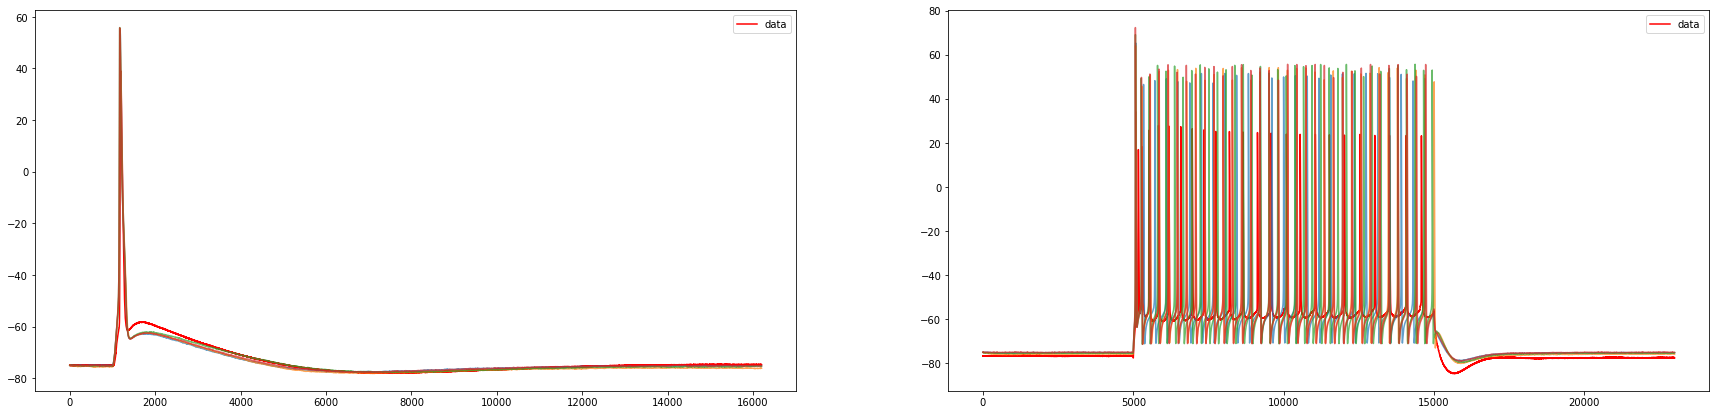

In [31]:
fig, ax = plt.subplots(ncols=2, figsize=(30, 7))

ax[0].plot(vr, c='r', label='data');

ax[1].plot(vs, c='r', label='data');

for i, tr in enumerate(traces_ramp): 
    ax[0].plot(tr, alpha=0.7)

for i, tr in enumerate(traces_step): 
    ax[1].plot(tr, alpha=0.7)
    
ax[0].legend()
ax[1].legend();



### Step Current

In [32]:
traces_ramp = df_best_step_tr.ramp_traces
traces_step = df_best_step_tr.step_traces
ids = df_best_step_tr.index

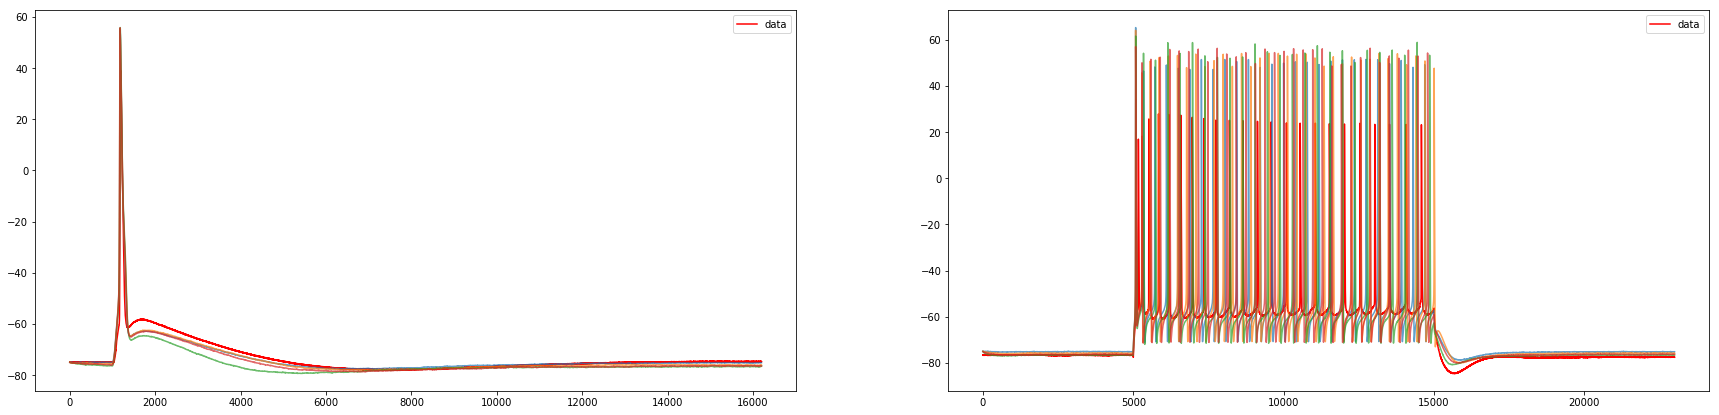

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(30, 7))

ax[0].plot(vr, c='r', label='data');
ax[1].plot(vs, c='r', label='data');

for i, tr in enumerate(traces_ramp): 
    ax[0].plot(tr, alpha=0.7)

for i, tr in enumerate(traces_step): 
    ax[1].plot(tr, alpha=0.7)
    
ax[0].legend()
ax[1].legend();


### Show the best Results

In [34]:
u_ramp = df_best_step_tr.loc[[6]].ramp_traces[6]
u_step = df_best_step_tr.loc[[6]].step_traces[6]

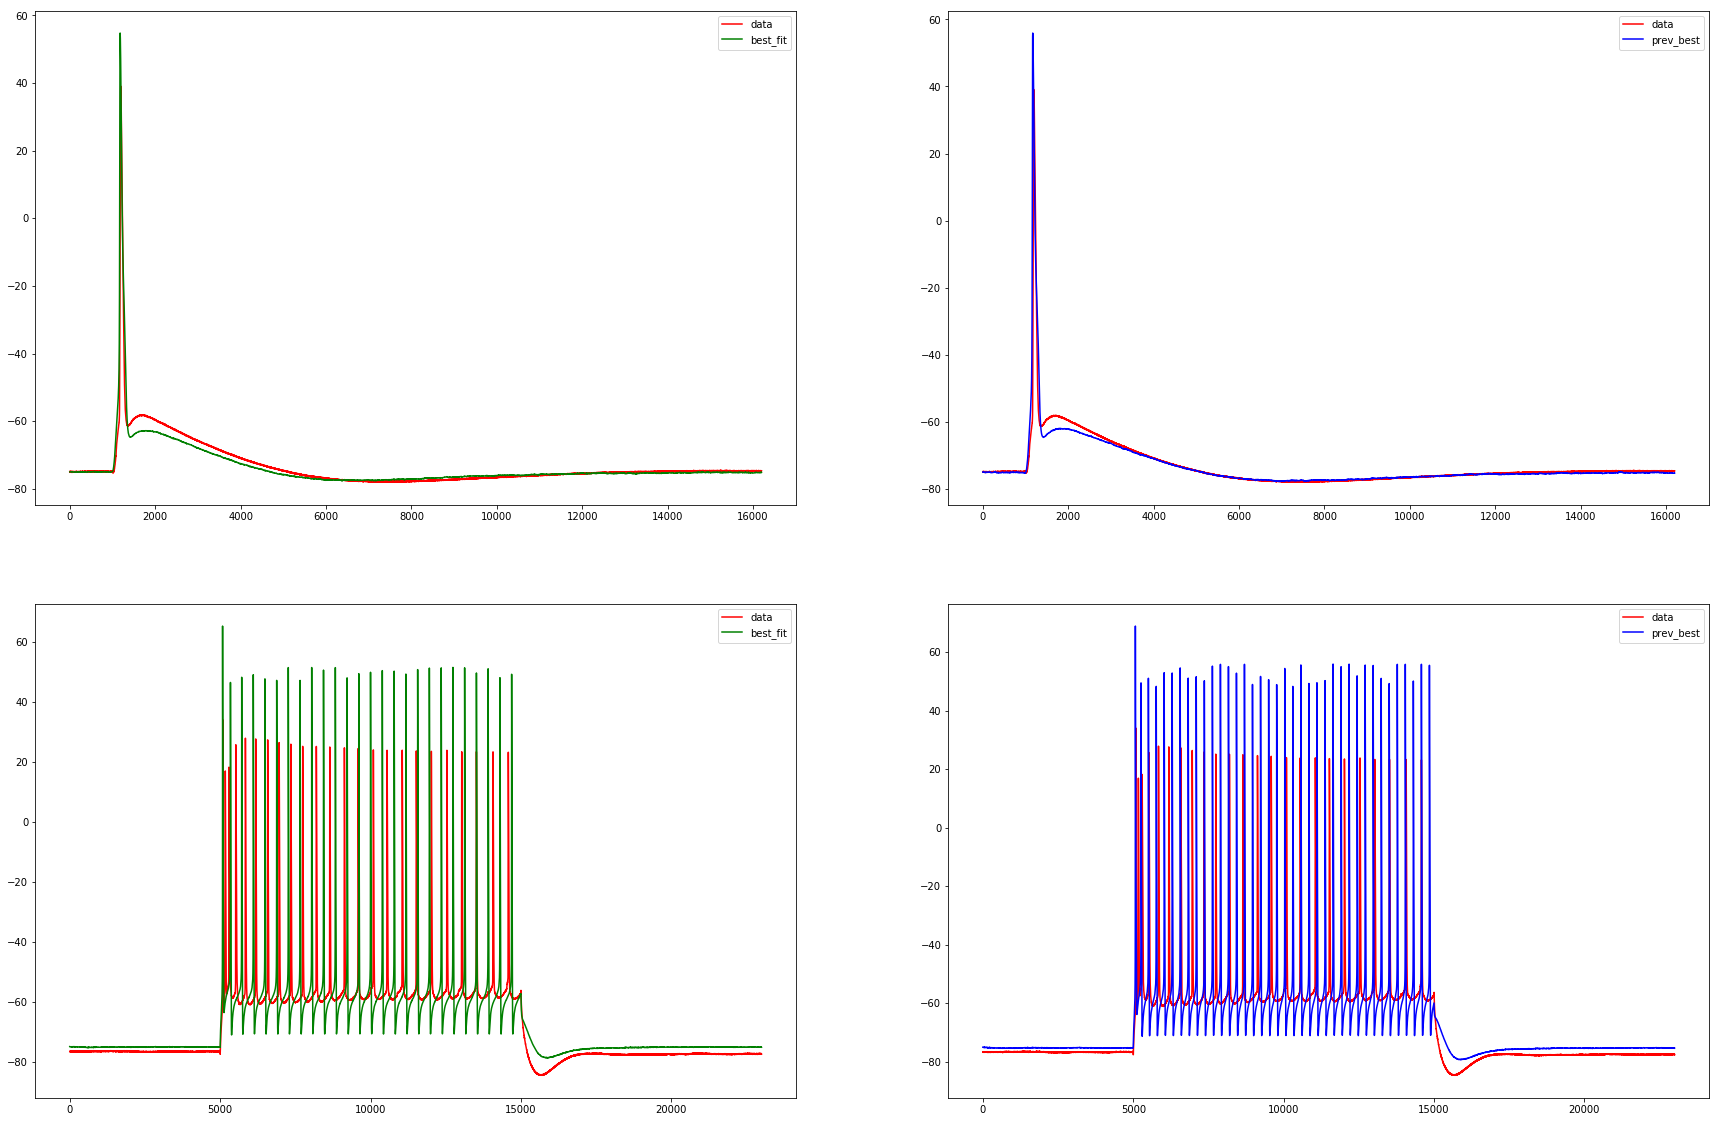

In [35]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(30, 20))

ax[0][0].plot(vr, c='r', label='data');
ax[0][1].plot(vr, c='r', label='data');
ax[1][0].plot(vs, c='r', label='data');
ax[1][1].plot(vs, c='r', label='data');

ax[0][0].plot(u_ramp, c='g', label='best_fit');
ax[1][0].plot(u_step, c='g', label='best_fit');

ax[0][1].plot(U_ramp, c='b', label='prev_best');
ax[1][1].plot(U_step, c='b', label='prev_best');

    
ax[0][0].legend()
ax[0][1].legend()
ax[1][0].legend();
ax[1][1].legend();

### Second Best Result

In [36]:
u_ramp = df_best_step_tr.loc[[7]].ramp_traces[7]
u_step = df_best_step_tr.loc[[7]].step_traces[7]

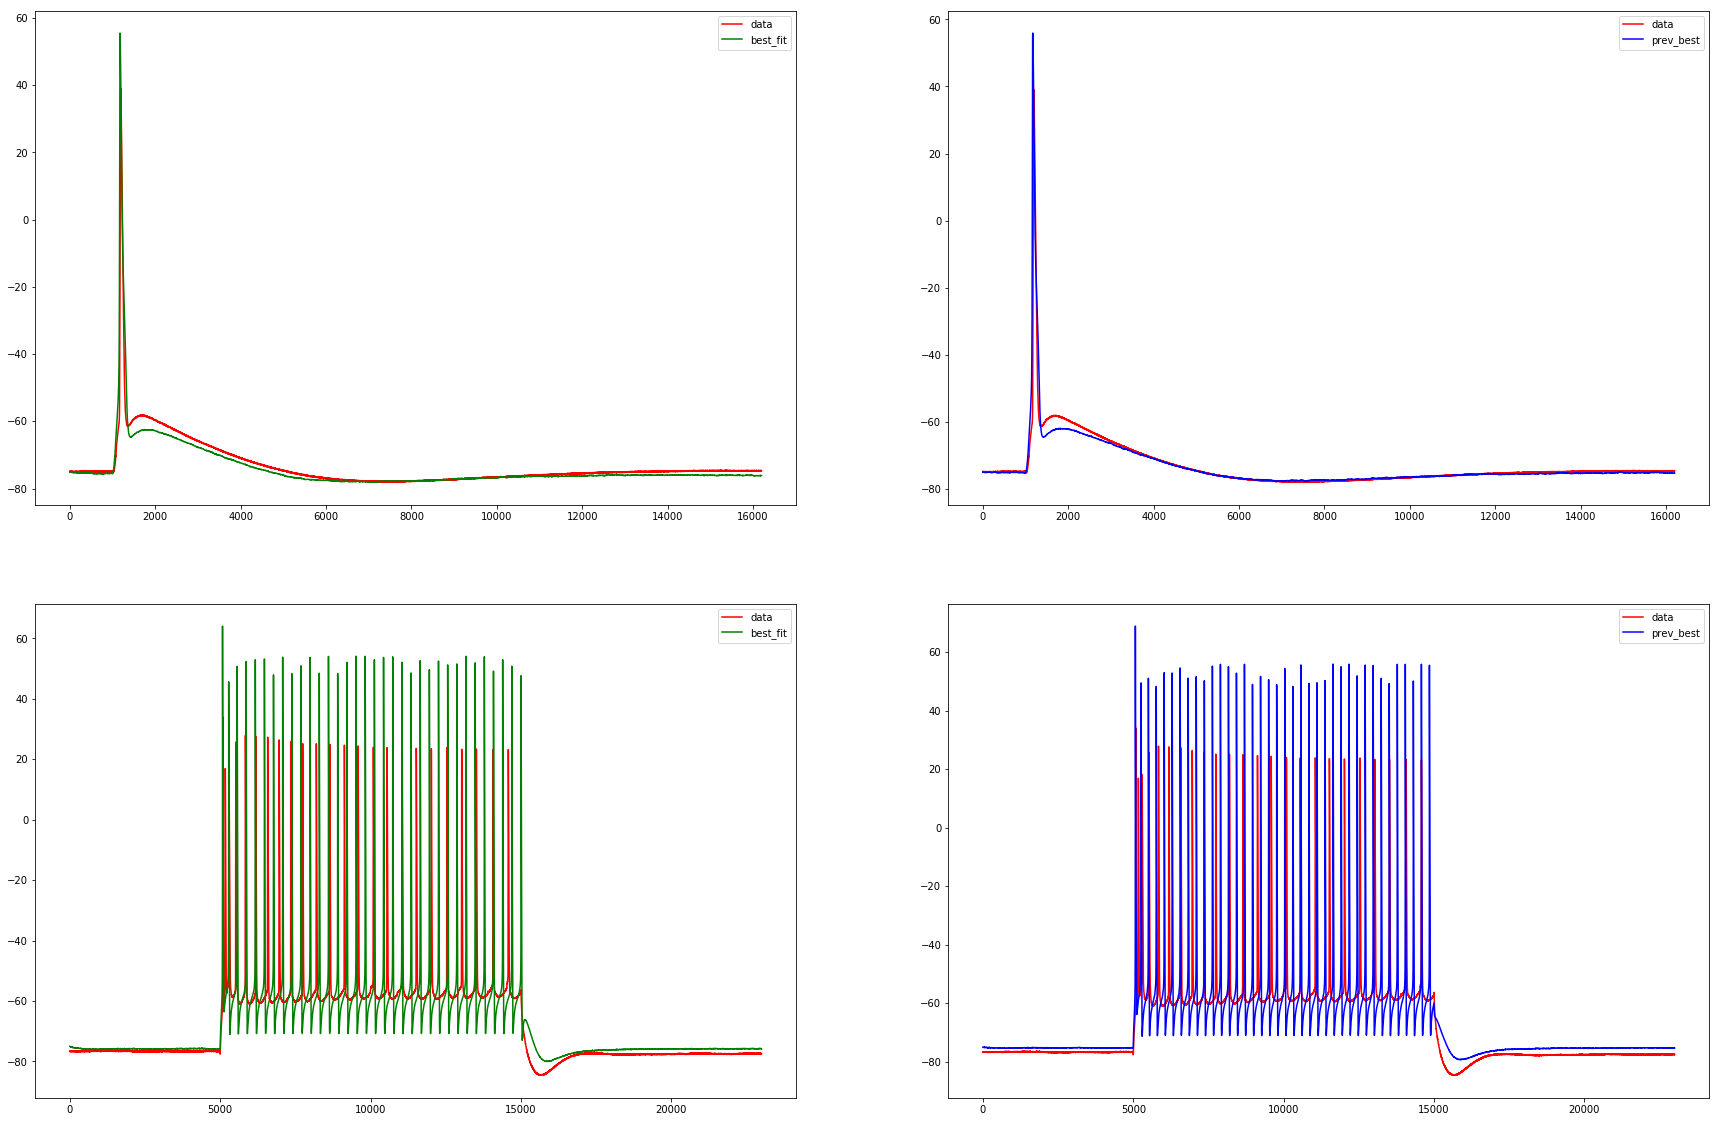

In [37]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(30, 20))

ax[0][0].plot(vr, c='r', label='data');
ax[0][1].plot(vr, c='r', label='data');
ax[1][0].plot(vs, c='r', label='data');
ax[1][1].plot(vs, c='r', label='data');

ax[0][0].plot(u_ramp, c='g', label='best_fit');
ax[1][0].plot(u_step, c='g', label='best_fit');

ax[0][1].plot(U_ramp, c='b', label='prev_best');
ax[1][1].plot(U_step, c='b', label='prev_best');

    
ax[0][0].legend()
ax[0][1].legend()
ax[1][0].legend();
ax[1][1].legend();

# Look at Distributions of Parameters

In [38]:
# param_labels = ['id','gbar_nap', 'gbar_leak', 'gbar_nat', 'gbar_kdr']
param_labels = ['gbar_nap', 'gbar_leak', 'gbar_nat', 'gbar_kdr', 'gbar_hcn']

df = df_traces[param_labels]
df2 = df_best_step_tr[param_labels]

df['label'] = 0
df2['label'] = 1

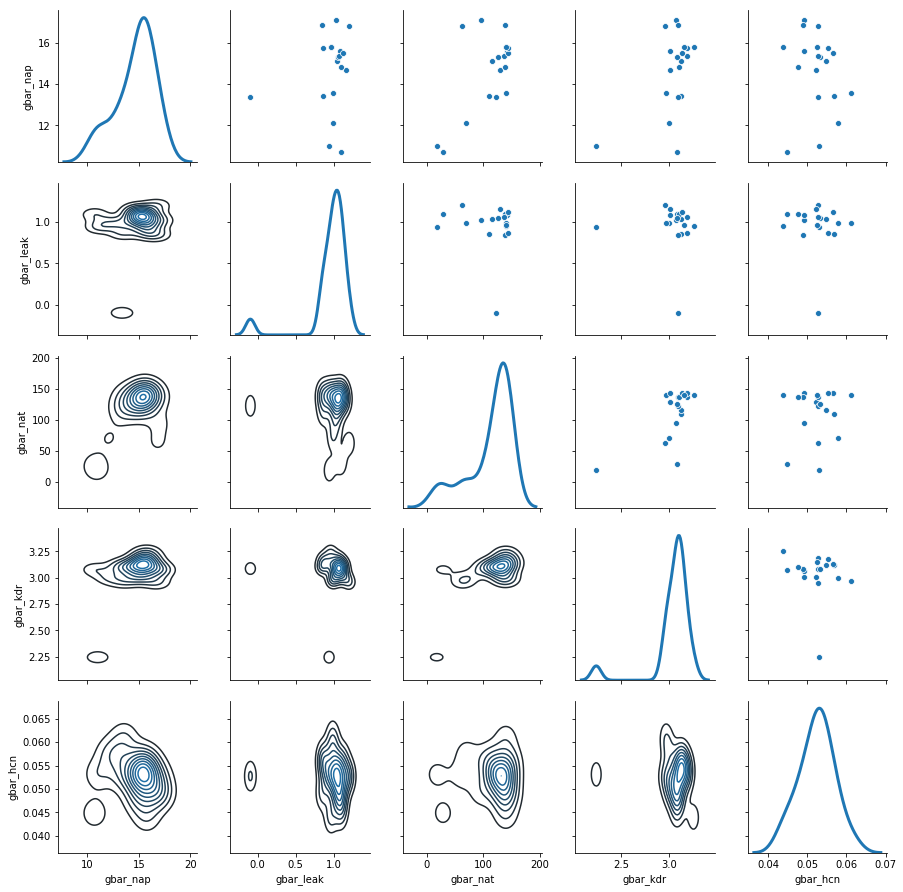

In [39]:
g = sns.PairGrid(df, vars=param_labels, diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3);

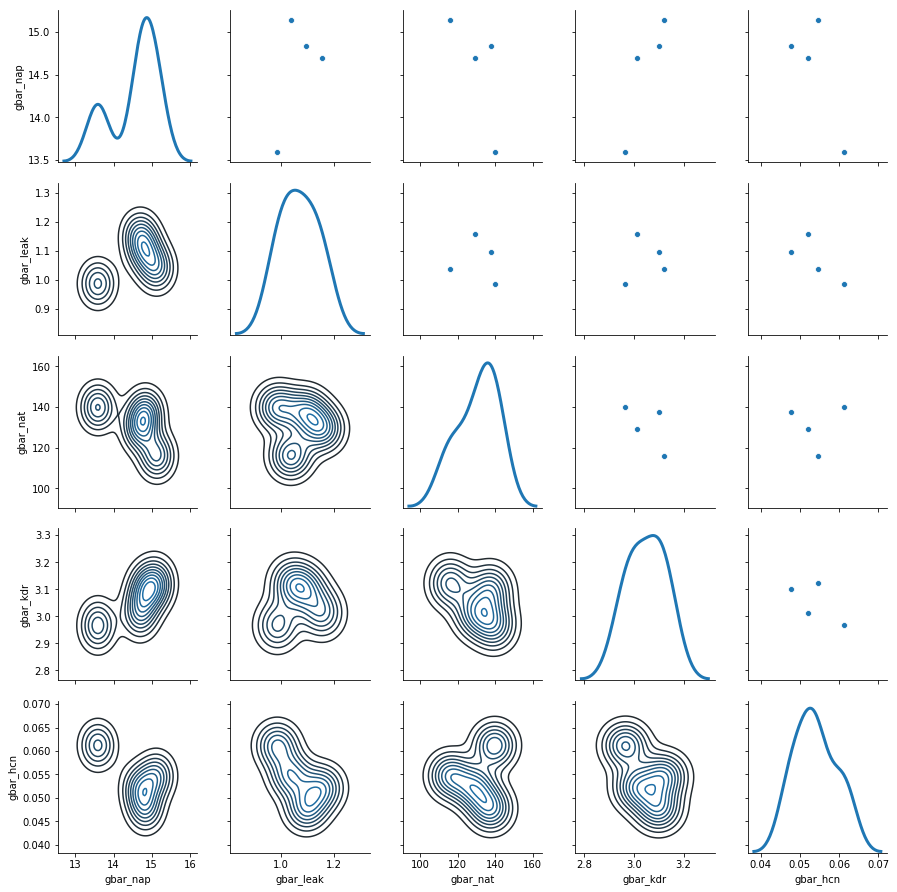

In [40]:
g2 = sns.PairGrid(df2, vars=param_labels, diag_sharey=False)
g2.map_lower(sns.kdeplot)
g2.map_upper(sns.scatterplot)
g2.map_diag(sns.kdeplot, lw=3)


In [42]:
df_double = pd.concat([df, df2])
df_double.head(3)

,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,gbar_hcn,label
id,,,,,,
0,10.995356,0.937945,17.965843,2.245691,0.053104,0
1,10.686955,1.095896,28.935782,3.078770,0.044835,0
2,16.832033,1.205391,62.270668,2.951745,0.052803,0


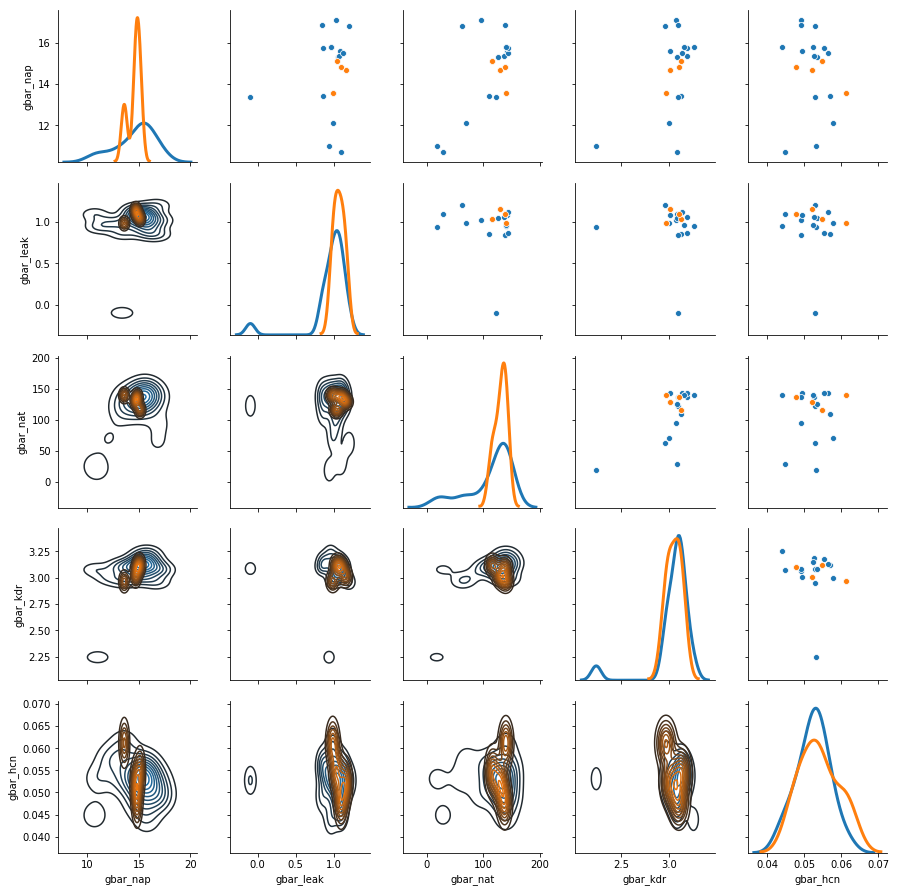

In [43]:
g3 = sns.PairGrid(df_double, vars=param_labels, hue='label', diag_sharey=False)
g3.map_lower(sns.kdeplot)
g3.map_upper(sns.scatterplot)
g3.map_diag(sns.kdeplot, lw=3)


## Best Results Actual Distributions

In [53]:
df_6_mean = df_best_step_tr.loc[[6]][param_labels]
df_7_mean = df_best_step_tr.loc[[7]][param_labels]


df_6_std = df_std.loc[[6]][param_labels]
df_7_std = df_std.loc[[7]][param_labels]

array([[1.51375470e+01, 1.03670230e+00, 1.15921851e+02, 3.12238188e+00,
        5.47447017e-02]])

In [57]:
df_6_std['gbar_nap'][6]

7.662505111408306

In [83]:
import math
import scipy.stats as stats

In [84]:
def plotable_distr(mu, variance):
    sigma = math.sqrt(variance)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

    return x, sigma

In [95]:
x

,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,gbar_hcn
id,,,,,
6,7.662505,0.593071,77.93573,0.712374,0.007246


In [87]:
mu = df_6_mean['gbar_nat'][6]
variance = df_6_std['gbar_nat'][6]
x, sigma = plotable_distr(mu, variance)

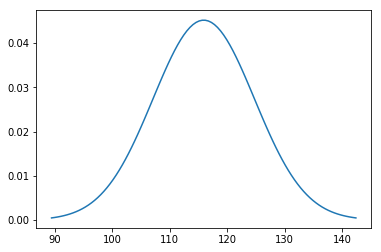

In [88]:
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

In [69]:
m = df_6_mean.to_numpy()[0]
P = df_6_std.to_numpy()[0]
m

array([1.51375470e+01, 1.03670230e+00, 1.15921851e+02, 3.12238188e+00,
       5.47447017e-02])